In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import PIL

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import imagestuff as ims

In [2]:
%matplotlib notebook

In [3]:
# Read the input dataset, including spacing in micrometers
imageroot = '20190702_case2.0'
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot,'A')
print("Filename, dx and dy", Filename, dx, dy)

# Load the image
im = PIL.Image.open(Filename)

SEMimages/20190702_case2.0-A.bmp
SEMimages/20190702_case2.0-B.bmp
SEMimages/20190702_case2.0-C.bmp
SEMimages/20190702_case2.0-D.bmp
Filename, dx and dy SEMimages/20190702_case2.0-A.bmp 0.7632211 0.7632211


The next cell has to be run multiple times, with adjustments to the Euler angles till there's a good fit.

In [4]:
class ExtlvecxAngleManager:
    def __init__(self, xorigin=0,yorigin=0,alpha=0,beta=0,gamma=0,scale=200):
        # Specify the origin and Euler angles
        self.xorigin = xorigin
        self.yorigin = yorigin
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.scale = scale
        

    def calculate_starts(self):
        # Lay out three vectors defining the orientation of the crystal
        # (before rotation)
        self.cvec_start = np.matrix([0,0,-1]).T; 
        self.avec_start = np.matrix([1,0,0]).T; 
        Rot60 = ims.myrotation_matrix(self.cvec_start,-120)
        self.bvec_start = Rot60*self.avec_start;

    def construct_rotation_matrices(self):
        # Construct the rotation matrix
        Rotalpha = ims.myrotation_matrix(np.matrix([0,0,1]).T,self.alpha)
        Rotbeta  = ims.myrotation_matrix(np.matrix([1,0,0]).T,self.beta)
        Rotgamma = ims.myrotation_matrix(np.matrix([0,0,1]).T,self.gamma)
        RotEuler = Rotgamma*Rotbeta*Rotalpha

        # Make the new vectors
        self.avec = RotEuler*self.avec_start
        self.bvec = RotEuler*self.bvec_start
        self.cvec = RotEuler*self.cvec_start

    def makeLine(self, x0, x1, y0, y1):
        """Turns endpoint coords into a graph-usable linspace format."""
        if x1<x0:
            x0,x1=x1,x0
            y0,y1=y1,y0
        x = np.linspace(x0,x1,num=100)
        y = np.linspace(y0,y1,num=100)
        return x,y

    def makeLines(self):
        """Returns graph-usable data for each of the three calibration lines."""

        # convert each line (A, B, and C) coordinite endpoints into arrays.
        xdataA, ydataA = self.makeLine(self.xorigin,
                                       self.xorigin+self.avec[0,0]*self.scale,
                                       self.yorigin,
                                       self.yorigin+self.avec[1,0]*self.scale)
        xdataB, ydataB = self.makeLine(self.xorigin,
                                       self.xorigin+self.bvec[0,0]*self.scale,
                                       self.yorigin,
                                       self.yorigin+self.bvec[1,0]*self.scale)
        xdataC, ydataC = self.makeLine(self.xorigin,
                                       self.xorigin+self.cvec[0,0]*self.scale,
                                       self.yorigin,
                                       self.yorigin+self.cvec[1,0]*self.scale)

        return xdataA,ydataA,xdataB,ydataB,xdataC,ydataC

    
    def update(self):

        # update rotation matrices
        self.construct_rotation_matrices()

<IPython.core.display.Javascript object>


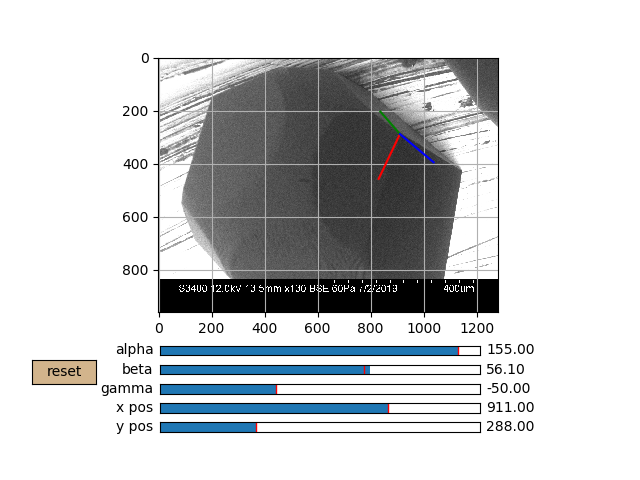

In [5]:
# setup angle manager
angleManager = ExtlvecxAngleManager(911,288,155,50,-50)
angleManager.calculate_starts()
angleManager.construct_rotation_matrices()

# make figure
fig, ax = plt.subplots()
## move main area up a little bit
plt.subplots_adjust(bottom=0.35)

# base setup
## display background image
plt.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
## misc
plt.grid(True)

# set data
## get the data for each of the three
x0,y0,x1,y1,x2,y2 = angleManager.makeLines()
### plt.plot returns two outputs, and we only want to save the first one,
### so a comma is needed
vecA, = plt.plot(x0,y0,color='red')
vecB, = plt.plot(x1,y1,color='green')
vecC, = plt.plot(x2,y2,color='blue')

# add sliders
axcolor = 'white'
## set areas (axes)
### format is [left, bottom, width, height]
ax0 = plt.axes([0.25, 0.10, 0.5, 0.02], facecolor=axcolor)
ax1 = plt.axes([0.25, 0.14, 0.5, 0.02], facecolor=axcolor)
ax2 = plt.axes([0.25, 0.18, 0.5, 0.02], facecolor=axcolor)
ax3 = plt.axes([0.25, 0.22, 0.5, 0.02], facecolor=axcolor)
ax4 = plt.axes([0.25, 0.26, 0.5, 0.02], facecolor=axcolor)
## designate areas (axes) as sliders
slider_ypos  = Slider(ax0,'y pos',0,im.size[1],valinit=angleManager.yorigin)
slider_xpos  = Slider(ax1,'x pos',0,im.size[0],valinit=angleManager.xorigin)
slider_gamma = Slider(ax2,'gamma',-180,180,valinit=angleManager.gamma)
slider_beta  = Slider(ax3,'beta', -180,180,valinit=angleManager.beta)
slider_alpha = Slider(ax4,'alpha',-180,180,valinit=angleManager.alpha)

# add reset button
## set area (axes)
axReset = plt.axes([0.05, 0.2, 0.1, 0.05])
## designate area (axes) as button
resetButton = Button(axReset, 'reset', color='tan')


def update(val):
    # this function is called every time a slider is moved.
    # It reads the sliders, and then updates the graph accordingly

    # read slider values, and send them to angleManager
    angleManager.xorigin = slider_xpos.val
    angleManager.yorigin = slider_ypos.val
    angleManager.alpha   = slider_alpha.val
    angleManager.beta    = slider_beta.val
    angleManager.gamma   = slider_gamma.val

    # update the angleManager with new information
    angleManager.update()

    # get each line and update the graph with them
    x0,y0,x1,y1,x2,y2 = angleManager.makeLines()
    vecA.set_xdata(x0)
    vecA.set_ydata(y0)
    vecB.set_xdata(x1)
    vecB.set_ydata(y1)
    vecC.set_xdata(x2)
    vecC.set_ydata(y2)

    # update graph visual
    fig.canvas.draw_idle()

# link each slider to update()
slider_xpos.on_changed(update)
slider_ypos.on_changed(update)
slider_alpha.on_changed(update)
slider_beta.on_changed(update)
slider_gamma.on_changed(update)

def reset(event):
    # resets all sliders to original positions
    slider_xpos.reset()
    slider_ypos.reset()
    slider_alpha.reset()
    slider_beta.reset()
    slider_gamma.reset()

# link reset button to reset()
resetButton.on_clicked(reset)

# system-specific. Not sure when/if you'll need this:
plt.show()

In [6]:
# Specifying the angles and origin in an output file
xtlvecsfile = 'Xtlvecs.nml'
cfile = open(xtlvecsfile,'w')
cfile.write('&Xtlvecs\n')
cfile.write('   '+'xorigin = '+str(angleManager.xorigin) +'\n')
cfile.write('   '+'yorigin = '+str(angleManager.yorigin) +'\n')
cfile.write('   '+'avec = '+\
            str(angleManager.avec[0,0])+','+\
            str(angleManager.avec[1,0])+','+\
            str(angleManager.avec[2,0])+'\n')
cfile.write('   '+'bvec = '+\
            str(angleManager.bvec[0,0])+','+\
            str(angleManager.bvec[1,0])+','+\
            str(angleManager.bvec[2,0])+'\n')
cfile.write('   '+'cvec = '+\
            str(angleManager.cvec[0,0])+','+\
            str(angleManager.cvec[1,0])+','+\
            str(angleManager.cvec[2,0])+'\n')
cfile.write('/ \n')
cfile.close()